<a href="https://colab.research.google.com/github/NahinAlam001/CSE-465/blob/model/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os
import gdown
import zipfile
import torch
from torch import nn
from pathlib import Path
from typing import Dict, List
from tqdm.auto import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
gdown.download('https://drive.google.com/uc?id=1DLWHOlGDNeQNRRuonzaSgwNiT_J1NDx1', 'pcos.zip', quiet=False)
with zipfile.ZipFile('pcos.zip', 'r' ) as zip_ref:
  zip_ref.extractall()

data_path = Path('data')
image_path = data_path/'images'
train_dir = image_path/'train'
test_dir = image_path/'test'

Downloading...
From (original): https://drive.google.com/uc?id=1DLWHOlGDNeQNRRuonzaSgwNiT_J1NDx1
From (redirected): https://drive.google.com/uc?id=1DLWHOlGDNeQNRRuonzaSgwNiT_J1NDx1&confirm=t&uuid=e4131d2d-49d9-4763-835d-32107412ff2e
To: /content/pcos.zip
100%|██████████| 132M/132M [00:02<00:00, 50.3MB/s]


In [3]:
transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                  transform = transform)

class_names = train_data.classes
class_names

['infected', 'notinfected']

In [4]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_loader = DataLoader(dataset = train_data,
                          batch_size = BATCH_SIZE,
                          shuffle = True,
                          num_workers = NUM_WORKERS)

test_loader = DataLoader(dataset = test_data,
                          batch_size = BATCH_SIZE,
                          shuffle = False,
                          num_workers = NUM_WORKERS)


batch_img, batch_label = next(iter(train_loader))
batch_img.shape, batch_label.shape

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [5]:
class NahinGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_unit: int,
               output_shape: int)->None:

    super().__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_unit,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_unit,
                  out_channels = hidden_unit,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2))

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_unit,
                  out_channels = hidden_unit,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_unit,
                  out_channels = hidden_unit,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2))

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 13*13*hidden_unit,
                  out_features = output_shape))

  def forward(self, x):
    return self.classifier(self.conv_block2(self.conv_block1(x)))

In [6]:
model_0 = NahinGG(input_shape = 3,
                  hidden_unit = 10,
                  output_shape = len(class_names)).to(device)

summary(model_0, input_size = [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
NahinGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [7]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device
               ):

  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    #forward pass
    train_pred_logits = model(X)

    #calculate the loss
    loss = loss_fn(train_pred_logits, y)
    train_loss += loss.item()

    #optimizer zero grad
    optimizer.zero_grad()

    #backward propagation
    loss.backward()

    #optimizer step
    optimizer.step()

    train_pred_lables = torch.argmax(torch.softmax(train_pred_logits, dim=1), dim=1)
    train_acc += (train_pred_lables == y).sum().item()/len(train_pred_lables)

  #average loss and accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [8]:
def test_step(model = torch.nn.Module,
              dataloader = torch.utils.data.DataLoader,
              loss_fn = torch.nn.Module,
              device = device):

  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_lables = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      test_acc += (test_pred_lables == y).sum().item()/len(test_pred_lables)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

In [9]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int = 5,
          device = device):

  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)

    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn,
                                    device = device)

    print(f'Epoch {epoch} | Train Loss: {train_loss: .4f} | Train Accuracy: {train_acc: .4f} | Test Loss: {test_loss: .4f} | Test Accuracy: {test_acc: .4f}')

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [11]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                            lr = 1e-3)

from timeit import default_timer as timer

start_time = timer()
model_0_results = train(model = model_0,
                        train_dataloader = train_loader,
                        test_dataloader = test_loader,
                        loss_fn = loss_fn,
                        optimizer = optimizer,
                        epochs = NUM_EPOCHS,
                        device = device)
end_time = timer()

print(f'Total Training Time: {end_time - start_time: .3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | Train Loss:  0.2923 | Train Accuracy:  0.8709 | Test Loss:  0.2086 | Test Accuracy:  0.9124
Epoch 1 | Train Loss:  0.1266 | Train Accuracy:  0.9508 | Test Loss:  0.0541 | Test Accuracy:  0.9810
Epoch 2 | Train Loss:  0.0689 | Train Accuracy:  0.9723 | Test Loss:  0.0079 | Test Accuracy:  0.9980
Epoch 3 | Train Loss:  0.0058 | Train Accuracy:  0.9995 | Test Loss:  0.0032 | Test Accuracy:  1.0000
Epoch 4 | Train Loss:  0.0017 | Train Accuracy:  1.0000 | Test Loss:  0.0010 | Test Accuracy:  1.0000
Epoch 5 | Train Loss:  0.0009 | Train Accuracy:  1.0000 | Test Loss:  0.0007 | Test Accuracy:  1.0000
Epoch 6 | Train Loss:  0.0009 | Train Accuracy:  1.0000 | Test Loss:  0.0007 | Test Accuracy:  1.0000
Epoch 7 | Train Loss:  0.0004 | Train Accuracy:  1.0000 | Test Loss:  0.0004 | Test Accuracy:  1.0000
Epoch 8 | Train Loss:  0.0004 | Train Accuracy:  1.0000 | Test Loss:  0.0006 | Test Accuracy:  1.0000
Epoch 9 | Train Loss:  0.0003 | Train Accuracy:  1.0000 | Test Loss:  0.0003 | Tes

In [13]:
model_0_results

{'train_loss': [0.29228784669129576,
  0.12661124527698658,
  0.06885477259075727,
  0.005838520196075628,
  0.0017078549625858003,
  0.0008898411472385261,
  0.0009460046646724594,
  0.0004377561320429553,
  0.0003751250303035018,
  0.00027937125291287645],
 'train_acc': [0.8709016393442623,
  0.9508196721311475,
  0.9723360655737705,
  0.9994877049180327,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'test_loss': [0.2085506347786696,
  0.05412714545363102,
  0.007885835142547823,
  0.0031782052112068995,
  0.0010188700808746527,
  0.0007397172526818067,
  0.0006994838052333598,
  0.00041436594777924705,
  0.0005524774006092036,
  0.000329938589245893],
 'test_acc': [0.9123975409836066,
  0.9810450819672131,
  0.9979508196721312,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]}

###Plot the loss curves of model_0

In [14]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [25]:
def plot_loss_curves(results: Dict[str, List[float]]):
    '''Plots training curve from our dict'''
    loss = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train loss')
    plt.plot(epochs, test_loss, label='test loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train accuracy')
    plt.plot(epochs, test_accuracy, label='test accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.show()

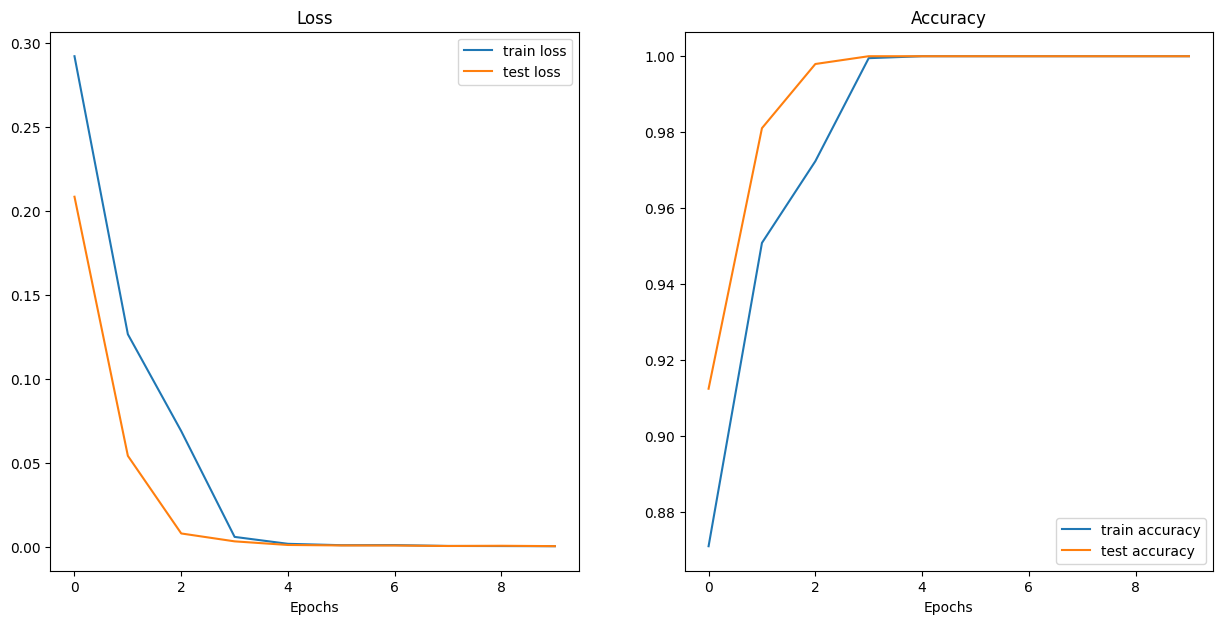

In [26]:
plot_loss_curves(model_0_results)